# Assignment 1
## Question `1` (K-Nearest Neighbour)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

### Instructions:
1.   Assignment must be implemented using python notebook only (Colab , VsCode , Jupyter etc.)
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for algorithms as well (sklearn etc). You are not however allowed to directly use classifier models.
3.   The performance of the model will hold weightage but you will also be graded largely for data preprocessing steps , explanations , feature selection for vectors etc.
4.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

### The Dataset
The dataset is avaible in the zip file which is a collection of *11099 tweets*. The data will be in the form of a csv file. The ground truth is also given in the zip file which corresponds to whether a tweet was popular or not. Since the task involves selecting features yourself to vectorize a tweet , we suggest some data analysis of the columns you consider important.
<br><br>

### The Task
You have to build a classifier which can predict the popularity of the tweet, i.e , if the tweet was popular or not. You are required to use **KNN** algorithm to build the classifier and cannot use any inbuilt classifier. All columns are supposed to be analyzed , filtered and preprocessed to determine its importance as a feature in the vector for every tweet (Not every column will be useful).<br>
The Data contains the **raw text of the tweet**(in the text column) as well as other **meta data** like likes count , user followers count. Note that it might be useful to **create new columns** with useful information. For example, *number of hashtags* might be useful but is not directly present as a column.<br>
There are 3 main sub parts:
1. *Vectorize tweets using only meta data* - likes , user followers count , and other created data
2. *Vectorize tweets using only it's text*. This segment will require NLP techniques to clean the text and extract a vector using a BoW model. Here is a useful link for the same - [Tf-Idf](https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d). Since these vectors will be very large , we recommend reducing their dimensinality (~10 - 25). Hint: [Dimentionality Reduction](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491). Please note that for this also you are allowed to use libraries.

3. *Combining the vectors from above two techinques to create one bigger vector*
<br>


Using KNN on these vectors build a classifier to predict the popularity of the tweet and report accuracies on each of the three methods as well as analysis. You can use sklearn's Nearest Neighbors and need not write KNN from scratch. (However you cannot use the classifier directly). You are expected to try the classifier for different number of neighbors and identify the optimal K value.

## Import necessary libraries

In [16]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

## Load and display the data

In [17]:
df_labels= pd.read_csv('ground_truth.csv',names=['gt'])

print(f'Columns= {df_labels.columns}',f'Data Size= {len(df_labels)}')
labels = [row['gt'] for ind, row in df_labels.iterrows()]
df_labels.info()

Columns= Index(['gt'], dtype='object') Data Size= 11099
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gt      11099 non-null  float64
dtypes: float64(1)
memory usage: 86.8 KB


In [18]:
df_attr= pd.read_csv('Tweets.csv')
attr_name= list(df_attr.columns)
attr={x:[] for x in attr_name }
for i,x in df_attr.iterrows():
    [attr[y].append(x[y]) for y in attr_name]
# print(f'Number of attributes= {len(attr_name)}',f'Data Size= {len(df_attr)}', 'Attributes: ')
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   created_at             11099 non-null  object 
 1   id                     11099 non-null  float64
 2   id_str                 11099 non-null  float64
 3   text                   11099 non-null  object 
 4   truncated              11099 non-null  bool   
 5   entities               11099 non-null  object 
 6   metadata               11099 non-null  object 
 7   source                 11099 non-null  object 
 8   is_quote_status        11099 non-null  bool   
 9   retweet_count          11099 non-null  int64  
 10  favorite_count         11099 non-null  int64  
 11  lang                   11099 non-null  object 
 12  user_name              11099 non-null  object 
 13  user_screen_name       11099 non-null  object 
 14  user_followers_count   11099 non-null  int64  
 15  us

In [19]:
t={print(f'>>>{x}; >>', attr[x][0]) for x in attr_name}


>>>created_at; >> Tue Jul 31 13:34:34 +0000 2018
>>>id; >> 1.02429e+18
>>>id_str; >> 1.02429e+18
>>>text; >> RT @EdwardTHardy: The 7th US Circuit Court of Appeals upheld a lower court ruling that blocked an Indiana mandate forcing women to undergoâ€¦
>>>truncated; >> False
>>>entities; >> {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'EdwardTHardy', 'name': 'Edward Hardy', 'id': 2369117648, 'id_str': '2369117648', 'indices': [3, 16]}], 'urls': []}
>>>metadata; >> {'iso_language_code': 'en', 'result_type': 'recent'}
>>>source; >> <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
>>>is_quote_status; >> False
>>>retweet_count; >> 113
>>>favorite_count; >> 0
>>>lang; >> en
>>>user_name; >> Sherry Wahl
>>>user_screen_name; >> queenfancygirl
>>>user_followers_count; >> 153
>>>user_friends_count; >> 264
>>>user_listed_count; >> 7
>>>user_created_at; >> Thu Mar 18 19:16:31 +0000 2010
>>>user_favourites_count; >> 32984
>>>user_verified; >> 

In [20]:
#entities column
entity = df_attr['entities'].apply(lambda x: eval(x))
NumOfHash = [len(x['hashtags']) for x in entity]
# print(NumOfHash)
NumOfSymbols=[len(x['symbols']) for x in entity]
# print(NumOfSymbols)
NumOfUserMentions= [len(x['user_mentions']) for x in entity]
# print(NumOfUserMentions)
NumOfurls=[len(x['urls']) for x in entity]
# print(NumOfurls)


In [21]:
#metadata column
metadat= df_attr['metadata'].apply(lambda x: eval(x))
lan=df_attr['lang']
print([x['iso_language_code'] for x in metadat]==list(lan))
#users column
users= df_attr['user_name'].duplicated()
len(["YES" for x in users if x == True])
#lang is same as is_language_code


True


959

## Exploratory Data Analysis
*This is an ungraded section but is recommended to get a good grasp on the dataset*

/home/xenos/anaconda3/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xenos/anaconda3/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xenos/anaconda3/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 144 (\x90) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


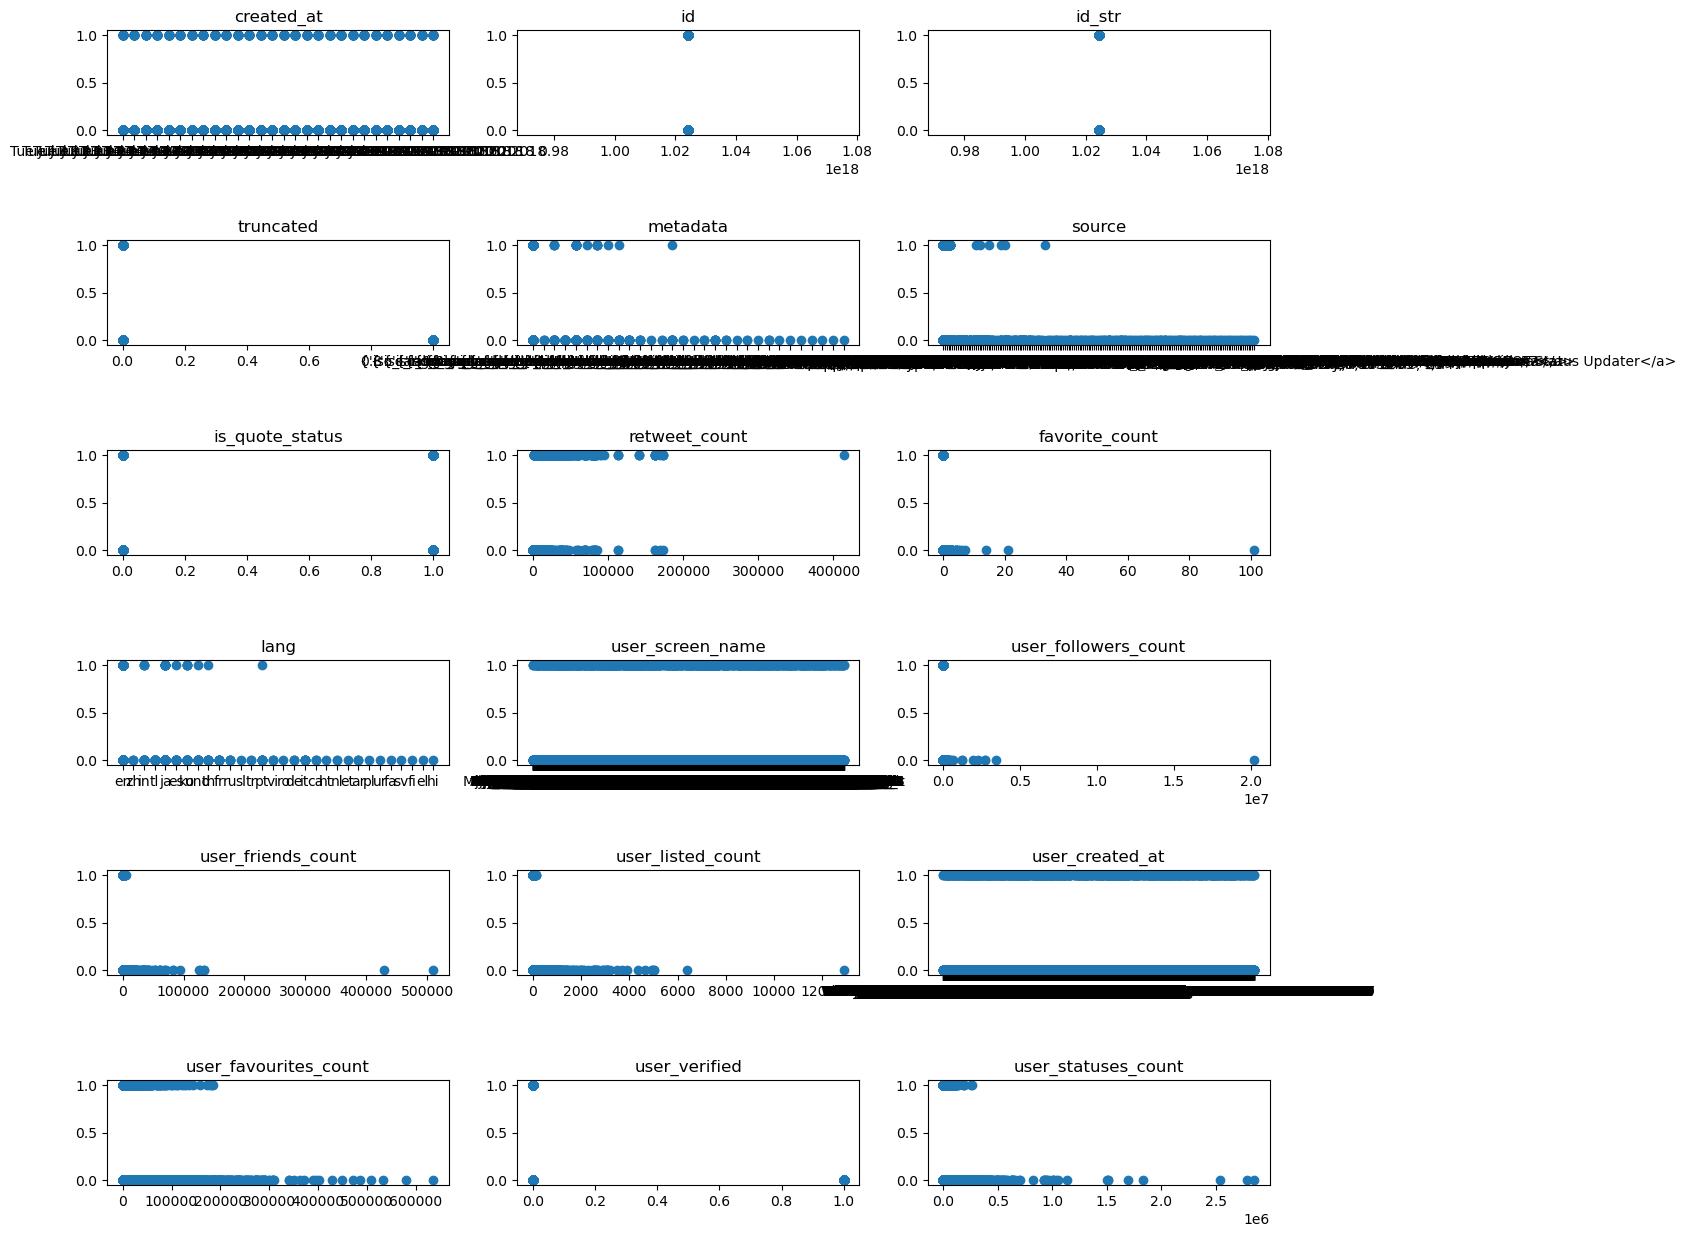

In [22]:
# Important metadata
import matplotlib.pyplot as plt
import matplotlib
# i=0
# plt.figure(figsize=(1000,100))
fig,axes = plt.subplots(6,3, figsize=(15,15))
ind=0
for r in range(6):
    for c in range(3):
        if (ind==3 or ind==5 or ind ==12):
            ind+=1
        axes[r,c].scatter(attr[attr_name[ind]],labels)
        axes[r,c].set_title(attr_name[ind])
        ind+=1
plt.subplots_adjust(hspace=1)
plt.show()

# truncated, is_quote_status, retweet_count, favorite_count, lang, 
# user_followers_count, user_friends_count, user_listed_count, user_favourites_count,user_verified, user_statuses_count
# + added columns

In [23]:
df_attr['hashtag_count'] =NumOfHash
df_attr['symbols_count'] = NumOfSymbols
df_attr['url_count']=NumOfurls
df_attr['user_mentions_count']=NumOfUserMentions
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   created_at             11099 non-null  object 
 1   id                     11099 non-null  float64
 2   id_str                 11099 non-null  float64
 3   text                   11099 non-null  object 
 4   truncated              11099 non-null  bool   
 5   entities               11099 non-null  object 
 6   metadata               11099 non-null  object 
 7   source                 11099 non-null  object 
 8   is_quote_status        11099 non-null  bool   
 9   retweet_count          11099 non-null  int64  
 10  favorite_count         11099 non-null  int64  
 11  lang                   11099 non-null  object 
 12  user_name              11099 non-null  object 
 13  user_screen_name       11099 non-null  object 
 14  user_followers_count   11099 non-null  int64  
 15  us

## Part-1
*Vectorize tweets using only meta data*

In [24]:
def get_features(df,df_labels):
  """
  Funtion to return a matrix of dimensions (number of tweets, number of chosen features)
  Input parameters to this funcion are to be chosen as per requirement (Example: Loaded dataframe of the dataset) 
  """
  df_p1=df.drop(['created_at','id','id_str','text','entities','metadata','source','lang','user_name','user_screen_name','user_created_at'],axis=1)
  X=df_p1.to_numpy()
  y=df_labels.to_numpy()
  return X,y

X,Y=get_features(df_attr,df_labels)
print(X[0])
print(Y[0])

  # your code here

[False False 113 0 153 264 7 32984 False 31308 0 0 0 1]
[0.]


Perform KNN using the vector obtained from get_features() function. Following are the steps to be followed:
1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values. 

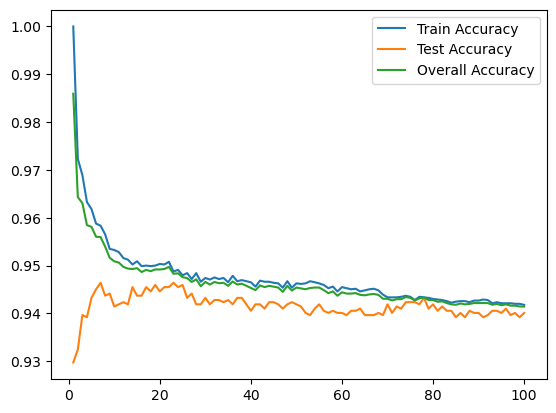

Accuracy = 0.9463963963963964 K=7; Predicted Class is chosen on the basis of majority voting


In [25]:
# your code here
def KNN(X,Y):
    X=normalize(X)
    train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.2)
    len(train_Y),len(test_Y) 
    K=[i for i in range(1,101)]
    train_acc=[]
    test_acc=[]
    acc=[]
    for k in K:
        neigh=NearestNeighbors(n_neighbors=k).fit(train_X)
        train_distances, train_indices = neigh.kneighbors(train_X)
        test_distances, test_indices = neigh.kneighbors(test_X)
        distances, indices = neigh.kneighbors(X)
        pred_train_Y, pred_test_Y, pred_Y=[],[],[]
        for x in train_indices:
            if(np.isscalar(train_Y[k])):
                lab=[train_Y[k] for k in x]
            else:
                lab=[train_Y[k][0] for k in x]
            pred_train_Y.append(np.bincount(lab).argmax())
        for x in test_indices:
            if(np.isscalar(train_Y[k])):
                lab=[train_Y[k] for k in x]
            else:
                lab=[train_Y[k][0] for k in x]
            pred_test_Y.append(np.bincount(lab).argmax())
        for x in indices:
            if(np.isscalar(train_Y[k])):
                lab=[train_Y[k] for k in x]
            else:
                lab=[train_Y[k][0] for k in x]
            pred_Y.append(np.bincount(lab).argmax())
        train_acc.append( accuracy_score(train_Y,pred_train_Y))
        test_acc.append( accuracy_score(test_Y,pred_test_Y))
        acc.append(accuracy_score(Y,pred_Y))
        # break/
    # print(train_acc)
    # print(test_acc)
    # print(acc)
    plt.plot(K,train_acc,label='Train Accuracy')
    plt.plot(K,test_acc, label="Test Accuracy")
    plt.plot(K,acc,label="Overall Accuracy")
    plt.legend(loc="upper right")
    plt.show()

    print(f'Accuracy = {np.max(test_acc)} K={1+np.argmax(test_acc)}; Predicted Class is chosen on the basis of majority voting')

KNN(X,Y)

## Part-2
Vectorize tweets based on the text. More details and reference links can be checked on the Tasks list in the start of the notebook

In [33]:
import re
from nltk.corpus import stopwords
from Stemmer import Stemmer
import nltk
nltk.download('stopwords')
def clean(text):
    stemmer = Stemmer('porter')
    s_w = set(stopwords.words('english'))
    s_w.add('rt')
    text=text.lower()
    clean_text =re.sub('http://\S+|https://\S+', '', text)
    clean_text= re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',clean_text)
    f=''
    for t in text: 
        w = stemmer.stemWord(t)
        if w not in s_w:
            w+=' '
            f+=t
    return f
# for text in df_attr['text']:
#     clean(text)

[nltk_data] Downloading package stopwords to /home/xenos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def tweet_vectoriser(df_attr,df_labels):
  """
  Funtion to return a matrix of dimensions (number of tweets, number of features extracted per tweet)
  Following are the steps for be followed:
    1. Remove links, tags and hashtags from each tweet.
    2. Apply TF-IDF on the tweets to extract a vector. 
    3. Perform dimensionality reduction on the obtained vector. 
  Input parameters to this funcion are to be chosen as per requirement (Example: Array of tweets) 
  """
  text = df_attr['text']
  Preprocessed_text = [clean(t) for t in text]
  vec = TfidfVectorizer()
  X_tweets = vec.fit_transform(Preprocessed_text) # 11099*21516
  TruncSVD= TruncatedSVD(n_components=14)
  X_tweets= TruncSVD.fit_transform(X_tweets)
  # pca =PCA(n_components=14)
  # X_tweets= pca.fit_transform(X_tweets)
  Y=df_labels['gt'].to_numpy()
  return X_tweets, Y
  
X_tweets,Y = tweet_vectoriser(df_attr,df_labels)
print(X_tweets[0])
print(Y[0])
  # your code here

[ 4.67987797e-02 -8.50639681e-03 -6.82389677e-03 -1.27483664e-02
  1.32836399e-02  2.59669281e-02 -1.71426521e-02  1.65024200e-02
 -1.32101741e-02 -1.67653396e-02  1.60291049e-05 -1.58190317e-02
 -1.28901327e-02  1.51839158e-02]
0.0


Perform KNN using the vector obtained from tweet_vectoriser() function. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

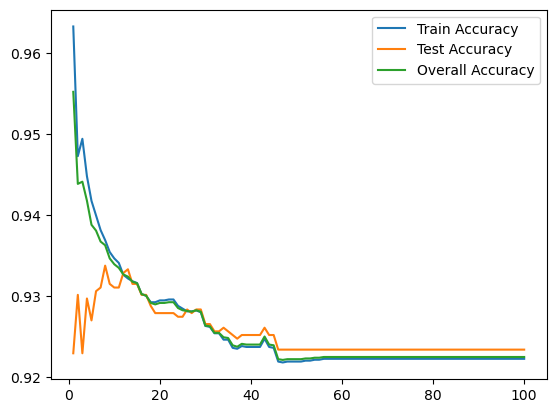

Accuracy = 0.9337837837837838 K=8; Predicted Class is chosen on the basis of majority voting


In [35]:
# your code here
KNN(X_tweets,Y)

## Part-3
### Subpart-1

Combine both the vectors obtained from the tweet_vectoriser() and get_features()

In [36]:
# your code here
print(X.shape,X_tweets.shape)
X_comb= np.concatenate((X,X_tweets),axis=1)
X_comb.shape

(11099, 14) (11099, 14)


(11099, 28)

Perform KNN using the vector obtained in the previous step. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

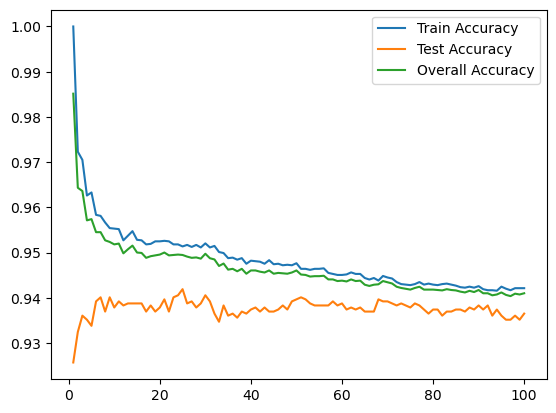

Accuracy = 0.9418918918918919 K=25; Predicted Class is chosen on the basis of majority voting


In [37]:
# your code here
KNN(X_comb,Y)

### Subpart-2

Explain the differences between the accuracies obtained in each part above based on the features used.

The accuracies obtained in the three cases is almost the same, however, the accuracy in 2nd and 3rd part is slight lower than the first.  
 In 2nd case, we reduced dimensionality using Truncated SVD, so there might be some loss in information there, thereby reducing the accuracy.   
 If a model has many features, it will predict with high variance, causing less accurate results. So, in the third case on combining the features the accuracy might drop due to over-fiting. 